In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff
from gene_expression_plots import survey_strain_nash_gene_exp, survey_strain_nash_gene_exp

In [2]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/04_Strains_AMLNtoControl/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

### Make tag directory to do motif calling

In [3]:
if not os.path.isdir('./motif_calling/'):
    os.mkdir('./motif_calling/')

# Correct merge-peaks shifting of atac peak files
Make atac peak file with 200bp peaks set on center of current peak (rounding down if fractional center)

In [5]:
atac_peaks = pd.read_csv('./merged_peaks/ann_raw_amln_control_idr_atac_peaks_merged.txt',
                         sep='\t', index_col=0)

In [6]:
new_start = []
new_end = []
for index, row in atac_peaks.iterrows():
    center = row.Start + int(np.floor((row.End - row.Start)/2))
    new_start.append(center - 100)
    new_end.append(center + 100)
    
atac_peaks_200bp = atac_peaks.iloc[:, :4].copy(deep=True)
atac_peaks_200bp['Start'] = new_start
atac_peaks_200bp['End'] = new_end
atac_peaks_200bp.index.rename('PeakID', inplace=True)

# Extract differential peaks

In [7]:
if not os.path.isdir('./nash_activated_peaks'):
    os.mkdir('./nash_activated_peaks')
    
if not os.path.isdir('./nash_repressed_peaks'):
    os.mkdir('./nash_repressed_peaks')

This code will read in each of the differential output files and select activated and repressed peaks according to the fold change cutoffs shown below.  

Next it writes out the activated and repressed peaks as well as a background peak set (all peaks that are not activated and repressed) that can be used as an improved background over randomly generated sequences for HOMER motif analysis.

In [9]:
# set p value and log2fc
padj = 0.05
log2fc = 1

peak_dict = {}

for i in glob.glob('./merged_peaks/*diff_output.txt'):
    diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
        i,
        './merged_peaks/ann_raw_amln_control_idr_atac_peaks_merged.txt')
    
    # log2fc is in position -3, adj p value is in position -1
    # positive peaks are up in nash, negative peaks are down in nash
    act = diff_peak.loc[(diff_peak.iloc[:, -3] >= log2fc) & (diff_peak.iloc[:, -1] < padj), :].index.tolist()
    rep = diff_peak.loc[(diff_peak.iloc[:, -3] <= -log2fc) & (diff_peak.iloc[:, -1] < padj), :].index.tolist()
    # write out peaks
    # active peaks
    atac_peaks_200bp.loc[act, :].to_csv(
        './nash_activated_peaks/'+i.split('/')[-1].split('_')[0]+'_act_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt',
        sep='\t')
        
    # active peaks background
    atac_peaks_200bp.loc[diff_peak.index.difference(act), :].to_csv(
        './nash_activated_peaks/'+i.split('/')[-1].split('_')[0]+'_bg_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt',
        sep='\t')
    
    # repressed peaks 
    atac_peaks_200bp.loc[rep, :].to_csv(
        './nash_repressed_peaks/'+i.split('/')[-1].split('_')[0]+'_rep_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt',
        sep='\t')
        
    # active peaks background
    atac_peaks_200bp.loc[diff_peak.index.difference(rep), :].to_csv(
        './nash_repressed_peaks/'+i.split('/')[-1].split('_')[0]+'_bg_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt',
        sep='\t')
        
    peak_dict[i.split('/')[-1].split('_')[0].replace('./','')] = [act, rep]
    
    # extract distal peaks only
    diff_peak_distal = diff_peak.loc[np.abs(diff_peak.loc[:, 'Distance to TSS']) >= 3000, :]
    
    actd = diff_peak_distal.loc[(diff_peak.iloc[:, -3] >= log2fc) & (diff_peak_distal.iloc[:, -1] < padj), :].index.tolist()
    repd = diff_peak_distal.loc[(diff_peak.iloc[:, -3] <= -log2fc) & (diff_peak_distal.iloc[:, -1] < padj), :].index.tolist()
    
    # write out peaks
    # active peaks
    atac_peaks_200bp.loc[actd, :].to_csv(
        './nash_activated_peaks/'+i.split('/')[-1].split('_')[0]+'_act_distal_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt',
        sep='\t')
        
    # active peaks background
    atac_peaks_200bp.loc[diff_peak_distal.index.difference(actd), :].to_csv(
        './nash_activated_peaks/'+i.split('/')[-1].split('_')[0]+'_bg_distal_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt',
        sep='\t')
    
    # repressed peaks 
    atac_peaks_200bp.loc[repd, :].to_csv(
        './nash_repressed_peaks/'+i.split('/')[-1].split('_')[0]+'_rep_distal_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt',
        sep='\t')
        
    # active peaks background
    atac_peaks_200bp.loc[diff_peak_distal.index.difference(repd), :].to_csv(
        './nash_repressed_peaks/'+i.split('/')[-1].split('_')[0]+'_bg_distal_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt',
        sep='\t')

annotatePeaks all peaks (75050, 30)
getDiffExpression selected transcripts (73615, 25)
annotatePeaks selected peaks (73615, 30)
annotatePeaks all peaks (75050, 30)
getDiffExpression selected transcripts (73615, 25)
annotatePeaks selected peaks (73615, 30)
annotatePeaks all peaks (75050, 30)
getDiffExpression selected transcripts (73615, 25)
annotatePeaks selected peaks (73615, 30)


## Write out BED files for visualization on browser

In [10]:
%%bash

# if directories don't exist, create them
if [ ! -d ./bed_files/ ]; then mkdir ./bed_files; fi

pos2bed.pl -o ./bed_files/aj_act_peaks_p_0.05_log2fc_1.bed \
-track 00_AJ_KC_nash_Activated_Peaks \
./nash_activated_peaks/aj_act_peaks_p_0.05_log2fc_1.txt

pos2bed.pl -o ./bed_files/balbc_act_peaks_p_0.05_log2fc_1.bed \
-track 01_BALB_KC_nash_Activated_Peaks \
./nash_activated_peaks/balbc_act_peaks_p_0.05_log2fc_1.txt

pos2bed.pl -o ./bed_files/C57_act_peaks_p_0.05_log2fc_1.bed \
-track 02_C57_KC_nash_Activated_Peaks \
./nash_activated_peaks/C57_act_peaks_p_0.05_log2fc_1.txt

pos2bed.pl -o ./bed_files/aj_rep_peaks_p_0.05_log2fc_1.bed \
-track 00_AJ_KC_nash_Repressed_Peaks \
./nash_repressed_peaks/aj_rep_peaks_p_0.05_log2fc_1.txt

pos2bed.pl -o ./bed_files/balbc_rep_peaks_p_0.05_log2fc_1.bed \
-track 01_BALB_KC_nash_Repressed_Peaks \
./nash_repressed_peaks/balbc_rep_peaks_p_0.05_log2fc_1.txt

pos2bed.pl -o ./bed_files/C57_rep_peaks_p_0.05_log2fc_1.bed \
-track 02_C57_KC_nash_Repressed_Peaks \
./nash_repressed_peaks/C57_rep_peaks_p_0.05_log2fc_1.txt

	Output File: ./bed_files/aj_act_peaks_p_0.05_log2fc_1.bed

	Converted 2615 peaks total

	Output File: ./bed_files/balbc_act_peaks_p_0.05_log2fc_1.bed

	Converted 184 peaks total

	Output File: ./bed_files/C57_act_peaks_p_0.05_log2fc_1.bed

	Converted 4773 peaks total

	Output File: ./bed_files/aj_rep_peaks_p_0.05_log2fc_1.bed

	Converted 1466 peaks total

	Output File: ./bed_files/balbc_rep_peaks_p_0.05_log2fc_1.bed

	Converted 111 peaks total

	Output File: ./bed_files/C57_rep_peaks_p_0.05_log2fc_1.bed

	Converted 3579 peaks total



# Check quality of differential peak calls

In [11]:
atac_peaks_200bp['location'] = atac_peaks_200bp.Chr+':'+atac_peaks_200bp.Start.astype(str)+'-'+atac_peaks_200bp.End.astype(str)

In [14]:
### set p value and log2fc
padj = 0.05
log2fc = 1

diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/aj_diff_output.txt',
    './merged_peaks/ann_raw_amln_control_idr_atac_peaks_merged.txt')

diff_peak = diff_peak.sort_values(
    diff_peak.columns[-1],
    ascending=True)

# log2fc is in position -3, adj p value is in position -1
# positive peaks are up in nash, negative peaks are down in nash
act = diff_peak.loc[(diff_peak.iloc[:, -3] >= log2fc) & (diff_peak.iloc[:, -1] < padj), :].index.tolist()
rep = diff_peak.loc[(diff_peak.iloc[:, -3] <= -log2fc) & (diff_peak.iloc[:, -1] < padj), :].index.tolist()

atac_peaks_200bp.loc[rep, :].head(10)

annotatePeaks all peaks (75050, 30)
getDiffExpression selected transcripts (73615, 25)
annotatePeaks selected peaks (73615, 30)


,Chr,Start,End,Strand,location
PeakID,,,,,
Merged-chr4-118107367-2,chr4,118107240,118107440,+,chr4:118107240-118107440
Merged-chr13-89383950-2,chr13,89383847,89384047,+,chr13:89383847-89384047
Merged-chr13-89384906-2,chr13,89384809,89385009,+,chr13:89384809-89385009
Merged-chr4-131920386-3,chr4,131920323,131920523,+,chr4:131920323-131920523
Merged-chr8-36952136-1,chr8,36952036,36952236,+,chr8:36952036-36952236
Merged-chr5-64342341-2,chr5,64342242,64342442,+,chr5:64342242-64342442
Merged-chr10-119063194-2,chr10,119063080,119063280,+,chr10:119063080-119063280
Merged-chr6-90462944-1,chr6,90462844,90463044,+,chr6:90462844-90463044
Merged-chr4-118106931-2,chr4,118106824,118107024,+,chr4:118106824-118107024


# Call motifs using homer

this needs to be done using the marge wrapper to shift mm10 coordinates back to their host genome.

In [15]:
strain_dict = {'C57': 'c57bl6j',
               'balbc': 'balbcj',
               'aj': 'aj'}

In [16]:
with open('./findMotifs_homer.sh', 'w') as f:
    
    for peakfile in np.sort(glob.glob('./nash_activated_peaks/*act*')):
        strain = peakfile.split('/')[-1].split('_')[0]
        outfile = peakfile.replace('nash_activated_peaks', 'motif_calling')
        outfile = outfile.replace('.txt', '_motifs')
        call = ['/home/vlink/code/marge/bin/MMARGE.pl', 'denovo_motifs',
                peakfile, 'mm10', outfile,
                '-bg', peakfile.replace('_act_', '_bg_'),
                '-len 8,10,12,14,16', '-fg_strain', strain_dict[strain],
                '-bg_strain', strain_dict[strain], '-p 8\n\n']
        f.write(' '.join(call))
        
    for peakfile in np.sort(glob.glob('./nash_repressed_peaks/*rep*')):
        strain = peakfile.split('/')[-1].split('_')[0]
        outfile = peakfile.replace('nash_repressed_peaks', 'motif_calling')
        outfile = outfile.replace('.txt', '_motifs')
        call = ['/home/vlink/code/marge/bin/MMARGE.pl', 'denovo_motifs',
                peakfile, 'mm10', outfile,
                '-bg', peakfile.replace('_rep_', '_bg_'),
                '-len 8,10,12,14,16', '-fg_strain', strain_dict[strain],
                '-bg_strain', strain_dict[strain], '-p 8\n\n']
        
        f.write(' '.join(call))
    f.close()

# Read in Known Motif Results

In [17]:
np.sort(glob.glob('./motif_calling/*/knownResults.txt'))

array([], dtype=float64)

In [18]:
known_motif_pval_dict = {}
for f in np.sort(glob.glob('./motif_calling/*/knownResults.txt')):    
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)

    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]

    # extract name of sample
    sample = f.split('/')[2]

    # store in dict
    known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame = known_motif_pval_frame.reindex(known_motif_pval_frame.mean(axis=1).sort_values().index.tolist())

known_motif_pval_frame.to_csv('./homer_known_motifs_log.txt', sep='\t')

# Plot known motif results

## Activated enhancers

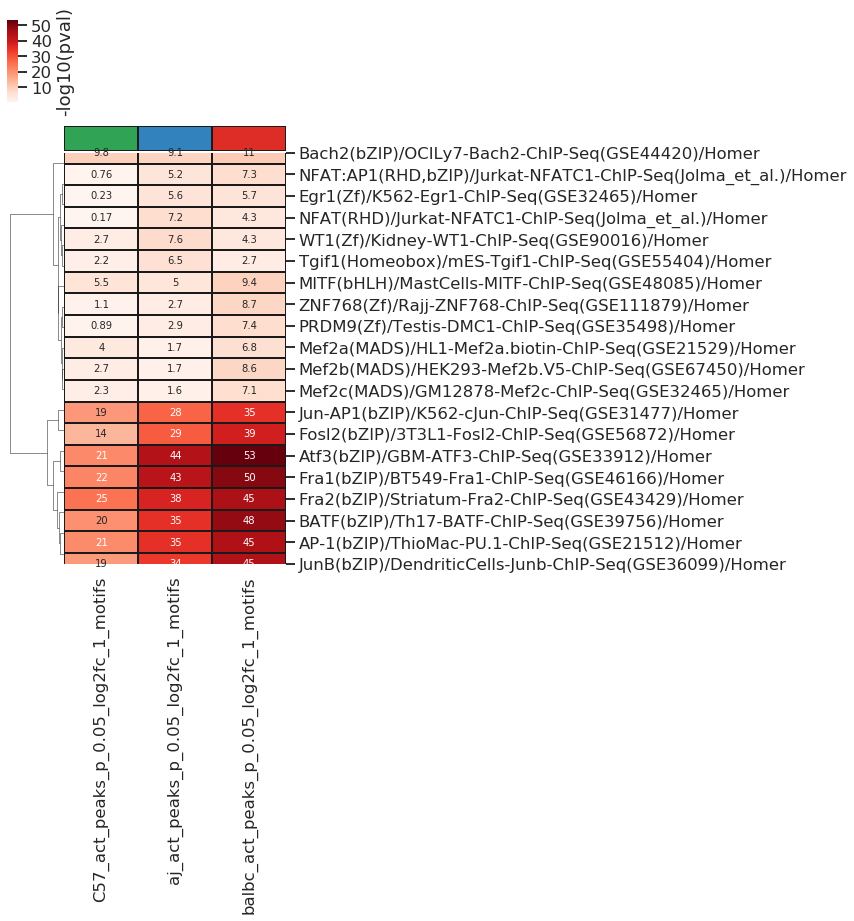

In [27]:
tmp_frame = known_motif_pval_frame.loc[:, ~known_motif_pval_frame.columns.str.contains('distal')]
tmp_frame = tmp_frame.loc[:, tmp_frame.columns.str.contains('_act_')]

# sort by new mean
tmp_frame = tmp_frame.reindex(
    tmp_frame.mean(axis=1).sort_values(ascending=True).index.tolist())

sns.clustermap(
    -tmp_frame.head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    # center=0,
    col_cluster=False,
    col_colors=['#31a354', '#de2d26', '#3182bd'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_enhancers.png',
            bbox_inches='tight')

### Select using highest score difference

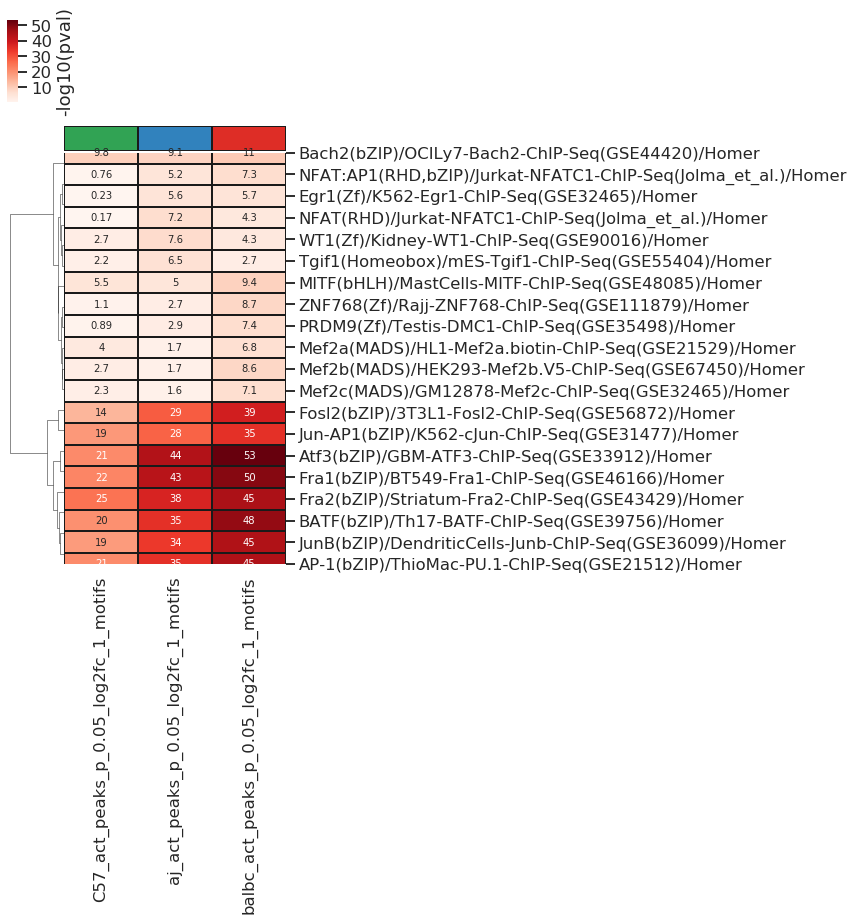

In [29]:
sns.clustermap(
    -tmp_frame.loc[(tmp_frame.max(1)-tmp_frame.min(1)).sort_values(ascending=False).index.tolist(), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    # center=0,
    col_cluster=False,
    col_colors=['#31a354', '#de2d26', '#3182bd'],
    figsize=(5,10))


plt.savefig('./figures/known_motif_strain_specific_maxdiff_enhancers.png',
            bbox_inches='tight')

## Activated distal enhancers

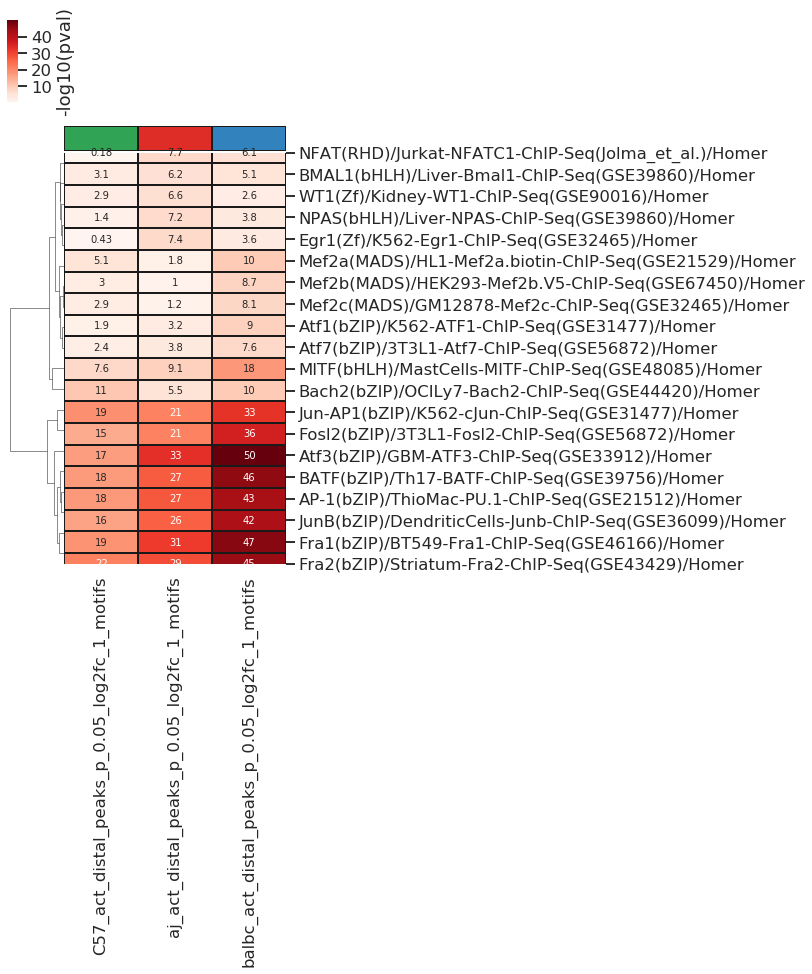

In [44]:
tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('distal')]
tmp_frame = tmp_frame.loc[:, tmp_frame.columns.str.contains('_act_')]

# sort by new mean
tmp_frame = tmp_frame.reindex(
    tmp_frame.mean(axis=1).sort_values(ascending=True).index.tolist())

sns.clustermap(
    -tmp_frame.head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    # center=0,
    col_cluster=False,
    col_colors=['#31a354', '#de2d26', '#3182bd'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_distal_enhancers.png',
            bbox_inches='tight')

### Select using highest score difference

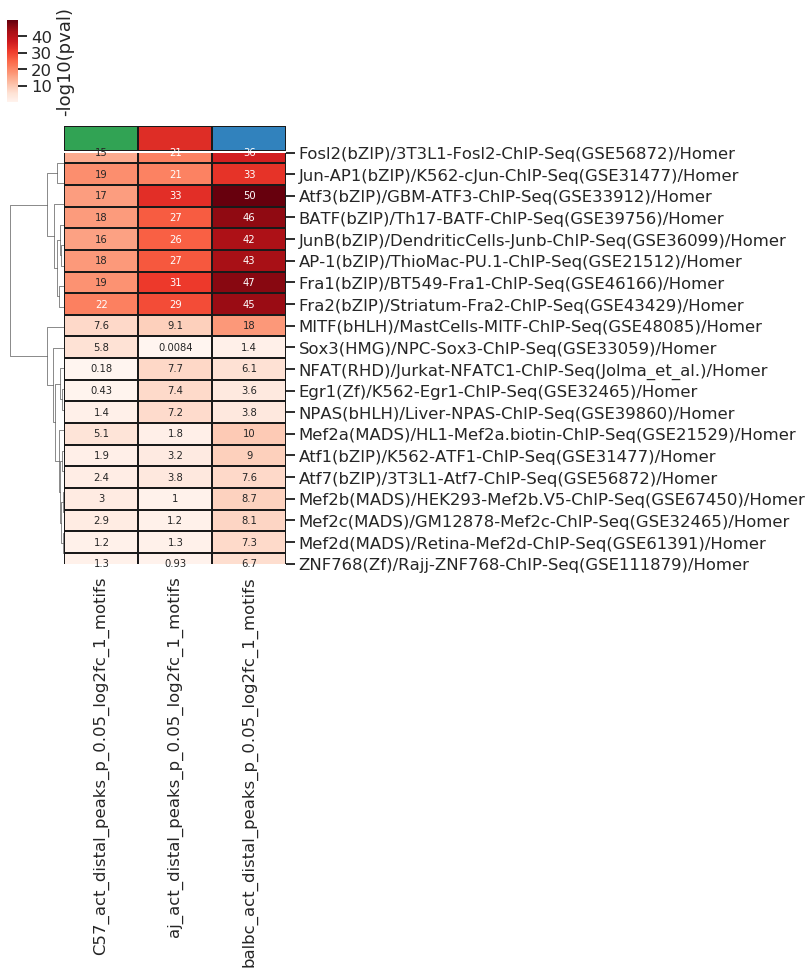

In [45]:
sns.clustermap(
    -tmp_frame.loc[(tmp_frame.max(1)-tmp_frame.min(1)).sort_values(ascending=False).index.tolist(), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    # center=0,
    col_cluster=False,
    col_colors=['#31a354', '#de2d26', '#3182bd'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_maxdiff_distal_enhancers.png',
            bbox_inches='tight')

## Repressed motifs

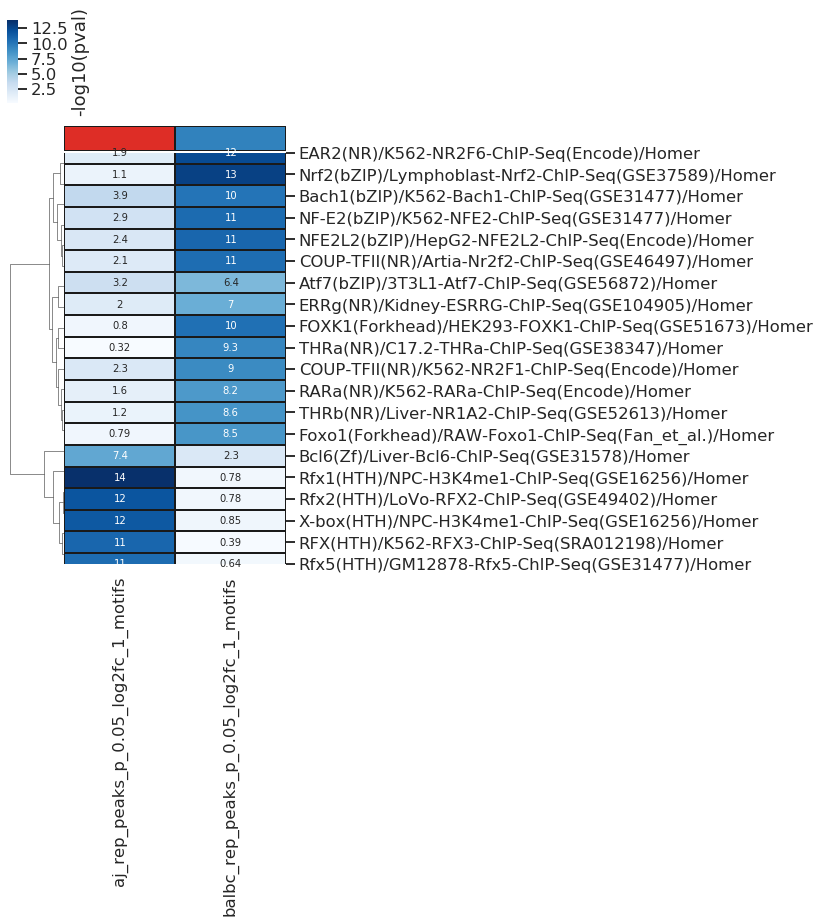

In [46]:
tmp_frame = known_motif_pval_frame.loc[:, ~known_motif_pval_frame.columns.str.contains('distal')]
tmp_frame = tmp_frame.loc[:, ~tmp_frame.columns.str.contains('_act_')]

# sort by new mean
tmp_frame = tmp_frame.reindex(
    tmp_frame.mean(axis=1).sort_values(ascending=True).index.tolist())

sns.clustermap(
    -tmp_frame.head(20),
    cmap='Blues',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    # center=0,
    col_cluster=False,
    col_colors=['#de2d26', '#3182bd'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_repressed_enhancers.png',
            bbox_inches='tight')

### Select using highest score difference

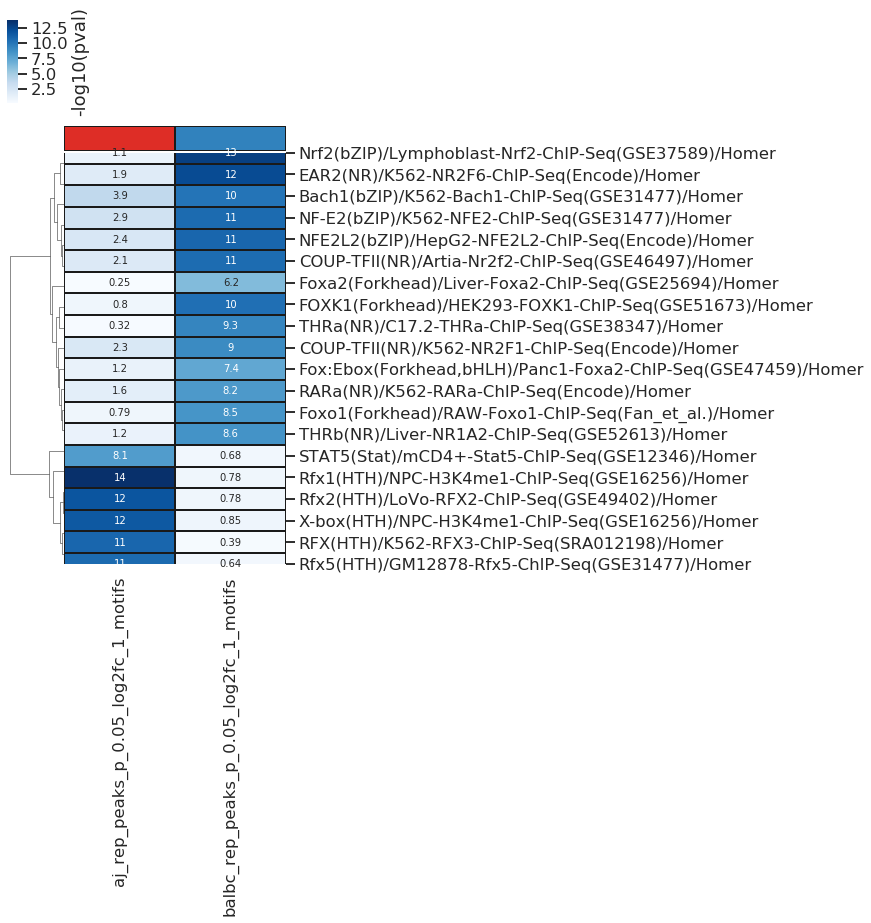

In [49]:
sns.clustermap(
    -tmp_frame.loc[(tmp_frame.max(1)-tmp_frame.min(1)).sort_values(ascending=False).index.tolist(), :].head(20),
    cmap='Blues',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    # center=0,
    col_cluster=False,
    col_colors=['#de2d26', '#3182bd'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_maxdiff_repressed_enhancers.png',
            bbox_inches='tight')

## Distal repressed enhancers

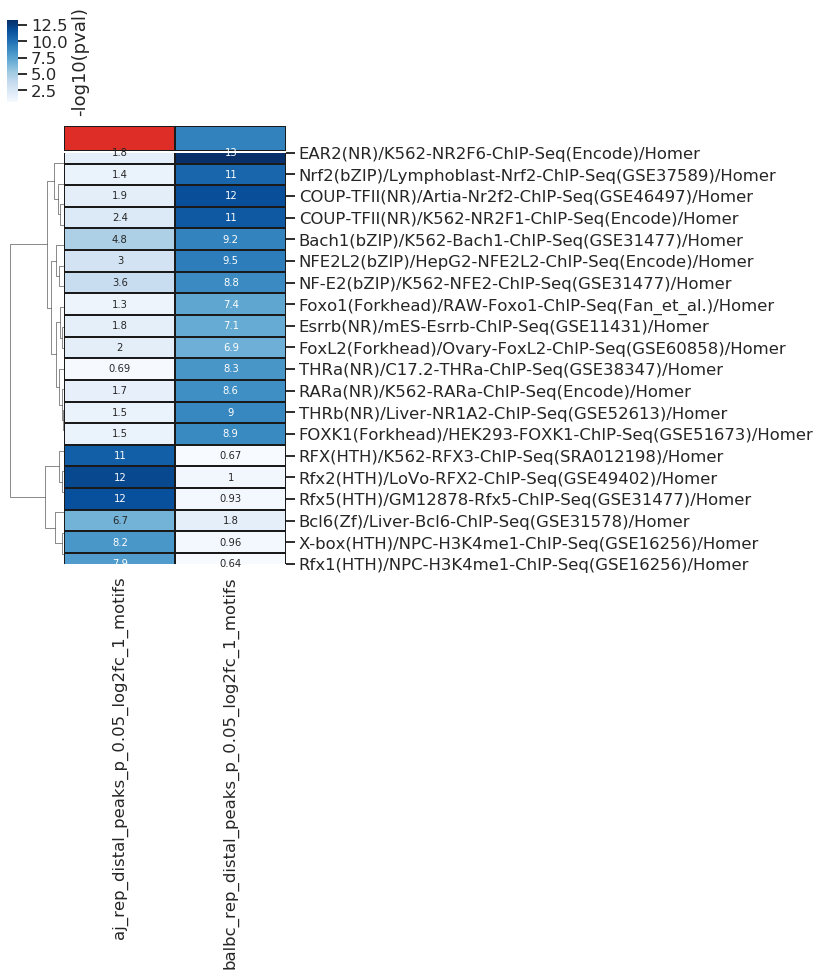

In [50]:
tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('distal')]
tmp_frame = tmp_frame.loc[:, ~tmp_frame.columns.str.contains('_act_')]

# sort by new mean
tmp_frame = tmp_frame.reindex(
    tmp_frame.mean(axis=1).sort_values(ascending=True).index.tolist())

sns.clustermap(
    -tmp_frame.head(20),
    cmap='Blues',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    # center=0,
    col_cluster=False,
    col_colors=['#de2d26', '#3182bd'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_repressed_distal_enhancers.png',
            bbox_inches='tight')

### Select using highest score difference

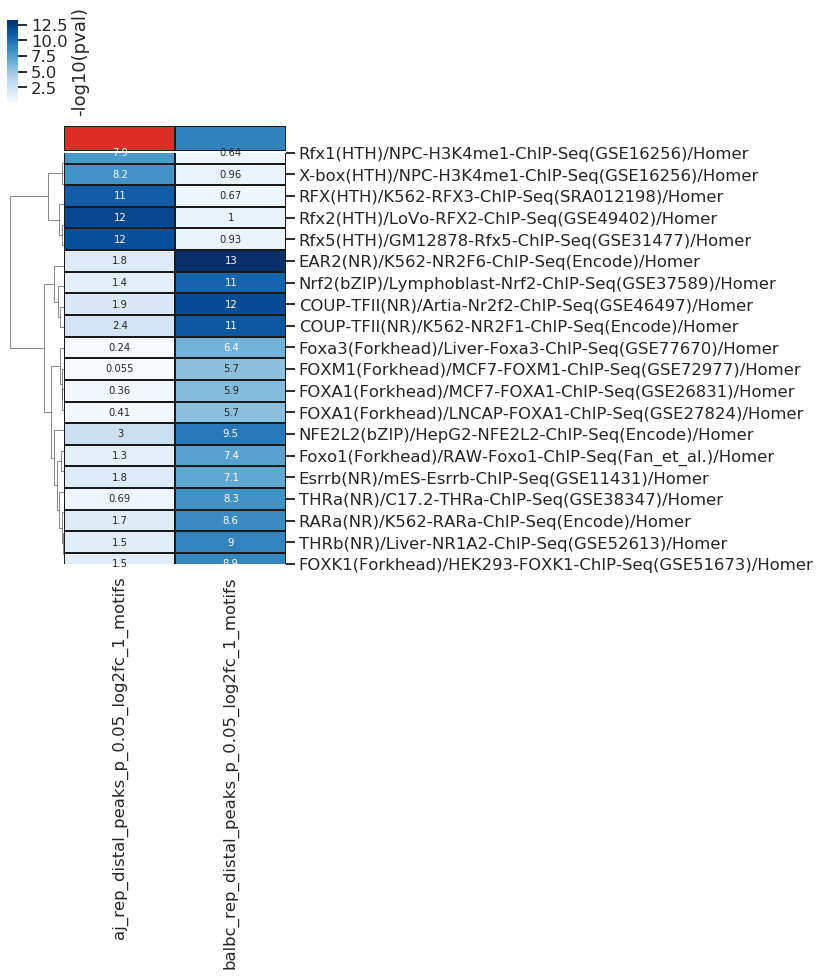

In [51]:
sns.clustermap(
    -tmp_frame.loc[(tmp_frame.max(1)-tmp_frame.min(1)).sort_values(ascending=False).index.tolist(), :].head(20),
    cmap='Blues',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    # center=0,
    col_cluster=False,
    col_colors=['#de2d26', '#3182bd'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_maxdiff_repressed_distal_enhancers.png',
            bbox_inches='tight')